<a href="https://colab.research.google.com/github/amyth18/CS598-Deep-Learning-Final-Project/blob/main/Main_Prediction_Model_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this notebook we provide our implementation for a disease prediction model based on discharge summary text. The implementation is based on the paper titled "[A disease inference method based on symptom extraction and bidirectional Long Short Term Memory networks](https://https://pubmed.ncbi.nlm.nih.gov/31301375/)" by Donglin Guo et al.

The notebook is divided in 4 parts.
1. Data Preprocessing
2. Feature Engineering
3. Model Training
4. Model Evaluation

The data preprocessing step needs to be performed only once and the output of this step can be used to run the other sections any number of times.

We have tested this notebook in Google Colab pro+ environment. We highly recommend using GPU when training the model.

We have used the MIMIC III dataset for training and testing our model, we specifically we need the `NOTEVENTS.csv` and `DIAGNOSES_ICD.csv` files to make this model work.

We have used Google Drive as our presistence layer. If you want to use any other storage then you will have to modify the storage paths in the cells accordingly.

# Initial Setup

Load the required packages

In [ ]:
! pip install gensim --upgrade
! pip install psutil
! pip install transformers

In [99]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import pickle

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

import gensim
from os import path

Mount the Google Drive into colab environment. The Google Drive contains our dataset as well acts as persistence for intermdiate data, model and results.

In [100]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Project level settings

In [101]:
PROJECT_PATH = "/content/drive/My Drive/DLH Final Project"
W2V_MODEL_PATH = f"{PROJECT_PATH}/models/word2vec.model"

W2V_EMB_SIZE = 128
LSTM_HIDDEN_VEC_SIZE = 100
TRAINING_BATCH_SIZE = 400

# Data Preprocessing

In this section we perform the following pre-processing steps on out data set and produce a dataframe that is then used for feature engineering in the next section.

1.   We first find the top #50 ICD codes (i.e top 50 conditions that are commonly diagnosed in admissions)

2.   We then select only those adminisions from `df_icd_codes` dataframe that contain atleat one of the top #50 ICD9 codes.

3. We then perform inner join on the filtered `df_icd_codes` to the `df` (i.e. NOTEVENTS.csv) to select discharge summary text from only those admimissions that contain at least one top #50 ICD9 code.

4. We then generate Word2Vec embeddings using all the filtered discharge summaries using Gensim. This will be used later in feature engineering.

5. We then extract only the symptom phrases from the discharge summaries using a pre-trained BERT model. The symptoms will then form the input features (represented in 2 forms) for our prediction model. This step is performed Feature Engineering section.

The following diagram shows the data pre-processing pipeline.

<img src='https://drive.google.com/uc?id=1deg7uoKN9cd7LWleztiWTLCgBKg2r1KT'>

## Load Data

We are primarily interested in the following 2 files/tables from the MIMIC III dataset.
1.   NOTESEVENTS.csv (context discharge summary in "TEXT" field for each hospital admission.)
2.   DIAGNOSES_ICD.csv (contains ICD9 codes for conditions diagnosed in an admimission)



In [38]:
df = pd.read_csv(f"{PROJECT_PATH}/mimic3/NOTEEVENTS.csv")
df[["SUBJECT_ID", "HADM_ID", "TEXT"]].head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,SUBJECT_ID,HADM_ID,TEXT
0,22532,167853.0,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Admission Date: [**2119-5-4**] D...


In [39]:
df_icd_codes = pd.read_csv(
    f"{PROJECT_PATH}/mimic3/DIAGNOSES_ICD.csv")

df_icd_codes[["SUBJECT_ID", "HADM_ID", "ICD9_CODE"]].head(3)

,SUBJECT_ID,HADM_ID,ICD9_CODE
0,109,172335,40301
1,109,172335,486
2,109,172335,58281


## Data Filtering and Tranformation

Normalize disease codes i.e we select only the first three characters of the ICD9_CODE representing only the high level category of the disease.

In [40]:
df_icd_codes.dropna()
df_icd_codes['ICD9_CODE'] = df_icd_codes['ICD9_CODE'].astype("string")

In [41]:
df_icd_codes.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


Get top #50 ICD9 codes and create an index for each code.

In [42]:
counts = df_icd_codes["ICD9_CODE"].value_counts().head(50)
top_icd_codes = counts.index.to_list()

sorted_top_icd_codes = sorted(top_icd_codes)
icd_code_to_idx = dict((k, v) for v, k in enumerate(sorted_top_icd_codes))

Filter data to include admimission with top 50 diseases only and group and reorganize data in the following format <subject_id, hadm_id, [icd_code1, icd_code2 ...]>

In [43]:
df_admissions_with_top_diseases = \
df_icd_codes[df_icd_codes["ICD9_CODE"].isin(top_icd_codes)]

df_admissions_with_top_diseases = \
df_admissions_with_top_diseases.groupby(
['SUBJECT_ID', 'HADM_ID'])['ICD9_CODE'].apply(
        list).to_frame().reset_index()

Now select discharge summaries for the admimissions that contain atleast one of the top #50 ICD codes.

In [44]:
df_dataset = pd.merge(df, df_admissions_with_top_diseases, 
                       on=["SUBJECT_ID", "HADM_ID"])

df_dataset = df_dataset[df_dataset["CATEGORY"] 
                          == 'Discharge summary'].reset_index()

So our dataset now looks like this.

In [45]:
df_dataset = df_dataset[["SUBJECT_ID", "HADM_ID", "TEXT", "ICD9_CODE"]]
df_dataset.head(3)

,SUBJECT_ID,HADM_ID,TEXT,ICD9_CODE
0,22532,167853.0,Admission Date: [**2151-7-16**] Dischar...,"[42731, 2762, 5070, 5119]"
1,22532,167853.0,Admission Date: [**2151-7-16**] Dischar...,"[42731, 2762, 5070, 5119]"
2,13702,107527.0,Admission Date: [**2118-6-2**] Discharg...,"[51881, 486, 2761, 2449, 311]"


In [63]:
df_dataset.to_csv(f"{PROJECT_PATH}/mimic3/df_dataset.csv")

## Text Processing Utilities

In [53]:
def sanitize_text(text):
      test = text.strip()
      text = re.sub(r'\s\s+', ' ', text)
      text = re.sub(r'[^a-zA-z0-9\/\.\?\!\s;,\'\-]', '', text)
      text = re.sub(r'[\.\-\/\?\!;,]', ' ', text)
      text = re.sub(r'[\[\]]', '', text)
      return text

In [54]:
# TODO: adding some basic checks again need to make it better.
def sanitize_words(sentence):
  return [w.lower() for w in sentence if w not in eng_stop_words and not w.isdigit()]

## Generate Word2Vec Embeddings

### Text Extraction Utility

In [55]:
import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')

eng_stop_words =  stopwords.words('english')

class MySentences(object):
    def __init__(self, dframe):
        self.dframe = dframe

    def __iter__(self):
        for idx in range(len(self.dframe)):
          text = sanitize_text(self.dframe["TEXT"][idx])
          yield sanitize_words(text.split())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We generate Word2Vec embeddings on the raw discharge summary text. These embeddings will be used later when we extract only the symptoms from the dischage summaries and generate Word2Vec embedding for those symptoms. 

Note: This step needs to be done only once before start the of project.

In [56]:
# NOTE: We only need to perform this once at the start of the project.
w2v_model_path = W2V_MODEL_PATH
if not path.exists(w2v_model_path):
  sgen = MySentences(df_dataset) # a memory-friendly iterator
  model = gensim.models.Word2Vec(sgen, min_count=5, 
                                 vector_size=W2V_EMB_SIZE, 
                                 window=5, sg=1, 
                                 workers=4, sample=1e-05)
  model.save(w2v_model_path)

## Symptom Extraction Using BERT

### Symptom Extraction Utility

Performs data cleaning, curation and symptom extraction using pre-trained BERT model on clinical text.

In [57]:
from typing import List
import re
import nltk
from transformers import AutoTokenizer, pipeline,  AutoModelForTokenClassification

from nltk.corpus import stopwords
nltk.download('stopwords')

eng_stop_words =  stopwords.words('english')

class MySymptoms(object):
    def __init__(self, dframe):
        self.dframe = dframe
        tokenizer = AutoTokenizer.from_pretrained(
            "samrawal/bert-base-uncased_clinical-ner")
        model = AutoModelForTokenClassification.from_pretrained(
            "samrawal/bert-base-uncased_clinical-ner")
        symptom_extractor = pipeline('ner', model=model, tokenizer=tokenizer,
                                     device=0)
        text_anno = symptom_extractor(self.dframe["TEXT"].tolist(), 
                                           batch_size=256)
        self.data = list(zip(text_anno, self.dframe["TEXT"].tolist()))        

    def extract_symptoms(self, input_anno_text) -> List[str]:
      """
      The method extract the symptom phrases from the input
      """
      extractions, text = input_anno_text
      span_extract = []
      for extract in extractions:
        if 'problem' in extract['entity']:
          span_extract.append((extract['start'], extract['end']))

      # Check if this span_extract is empty
      if not span_extract:
        return []
      
      span_st = span_extract[0][0]
      final_span = []
      final_end = span_extract[0][1]
      for idx, (st, end) in enumerate(span_extract):
        if idx == 0:
          continue
        if st - span_extract[idx-1][1] <= 2:
          final_end = end
          if idx == len(span_extract) - 1:
            final_span.append((span_st, final_end))
        else:
          final_span.append((span_st, final_end))
          span_st = st
          final_end = end

      text_extracts = [text[st:end].replace("\n", " ") for st, end in final_span]
      return text_extracts

    def __iter__(self):
        for idx in range(len(self.dframe)):
          symptoms = " ".join(self.extract_symptoms(self.data[idx]))
          text = sanitize_text(symptoms)
          yield sanitize_words(text.split())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, extract only the phrases related to symptoms using pre-trained BERT model on clinical test from the discharge summary. In the paper the authoes have used MetaMap for this, we could not access MetaMap in time so we are using an alternate method. We intend to run our experiment with MetaMap during our final implementation.



In [58]:
from tqdm import tqdm
from os import path


df_dataset_bert = None

dataset_path = f"{PROJECT_PATH}/mimic3/df_dataset_bert.csv"
if not path.exists(dataset_path):
  # make a copy for transformations.
  df_dataset_bert = df_dataset.copy()  
  sgen = MySymptoms(df_dataset_bert)
  symptom_col = list()
  for s in tqdm(sgen):
    symptom_col.append(s)
  # add the new column to the dataset.
  df_dataset_bert["SYMPTOMS"] = symptom_col
  df_dataset_bert = df_dataset_bert[df_dataset_bert.apply(lambda x: len(x.SYMPTOMS) > 0, axis=1)]
  df_dataset_bert = df_dataset_bert.reset_index()
else:
  df_dataset_bert = pd.read_csv(f"{PROJECT_PATH}/mimic3/df_dataset-bert.csv",
                  converters={'SYMPTOMS': eval, 'ICD9_CODE': eval})

55988it [00:12, 4562.57it/s]


In [61]:
df_dataset_bert.head(5)

,index,SUBJECT_ID,HADM_ID,TEXT,ICD9_CODE,SYMPTOMS
0,0,22532,167853.0,Admission Date: [**2151-7-16**] Dischar...,"[42731, 2762, 5070, 5119]","[cavitary, lesions, left, lung, apex, infectio..."
1,1,22532,167853.0,Admission Date: [**2151-7-16**] Dischar...,"[42731, 2762, 5070, 5119]","[productive, cough, lb, weight, loss, shortnes..."
2,2,13702,107527.0,Admission Date: [**2118-6-2**] Discharg...,"[51881, 486, 2761, 2449, 311]","[emphysema, shortness, breath, copd, flare, fe..."
3,3,13702,167118.0,Admission Date: [**2119-5-4**] D...,"[496, 2762]","[copd, severe, tbm, perc, tr, failed, ach, cop..."
4,4,13702,196489.0,Admission Date: [**2124-7-21**] ...,"[5849, 2760, 2762, 41401, 2724, 2449, 4019]","[copd, exacerbation, shortness, breath, troduo..."


Save the final dataset to disk.

In [62]:
df_dataset_bert = df_dataset_bert[["SUBJECT_ID", "HADM_ID", "ICD9_CODE", "SYMPTOMS"]]
df_dataset_bert.to_csv(f"{PROJECT_PATH}/mimic3/df_dataset_bert.csv")

# Dataset Exploration

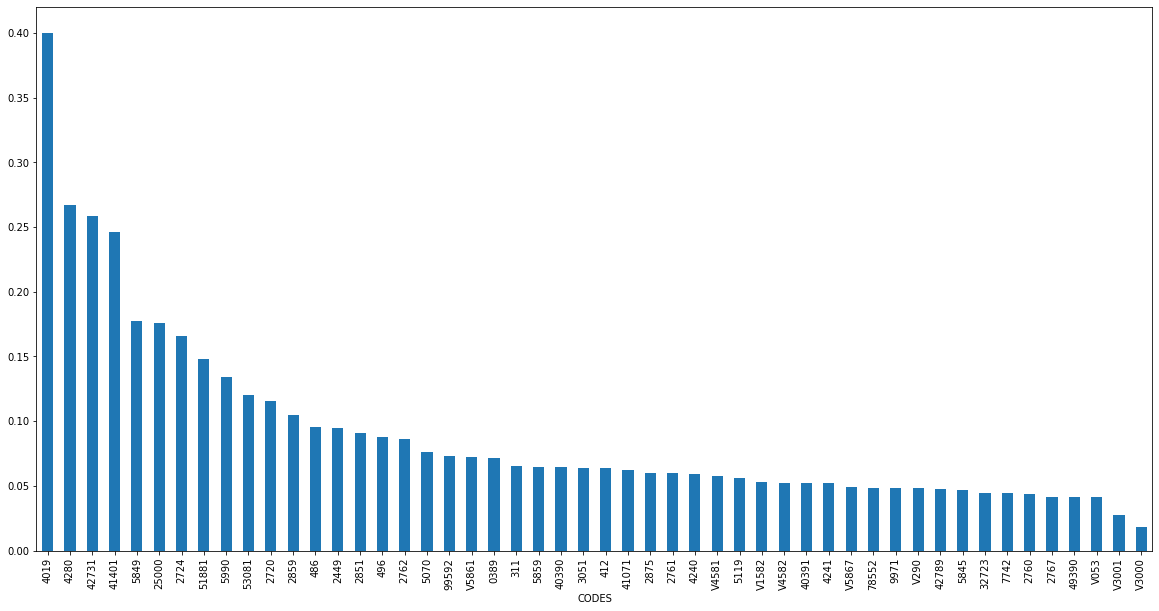

In [64]:
codes = [code for codes in df_dataset['ICD9_CODE'].to_list() \
            for code in codes]

codes_df = pd.DataFrame({
    "CODES": codes
})

code_counts = codes_df.groupby("CODES")["CODES"].count()
code_freq = code_counts.sort_values(ascending=False)/len(df_dataset)
code_freq.plot.bar(figsize=(20, 10))

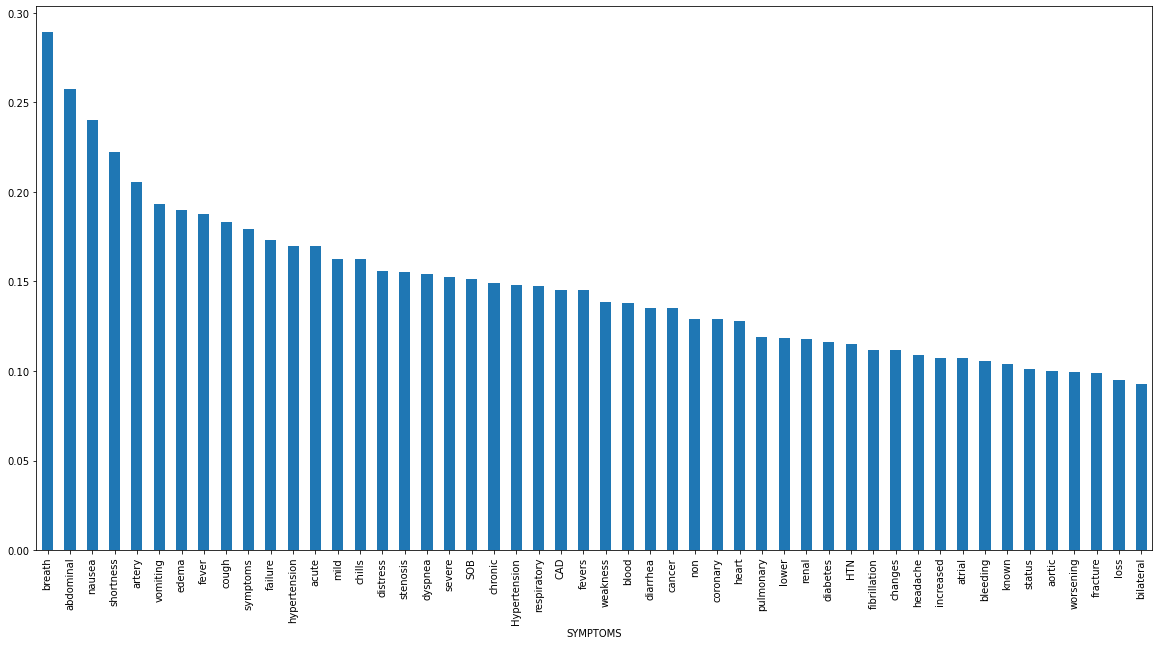

In [87]:
symptoms = [symptom for symptoms in df_dataset['SYMPTOMS'].to_list() \
            for symptom in symptoms]

symp_df = pd.DataFrame({
    "SYMPTOMS": symptoms
})

symptom_counts = symp_df.groupby("SYMPTOMS")["SYMPTOMS"].count()
symptom_freq = symptom_counts.sort_values(ascending=False)/len(df_dataset)
symptom_freq.head(50).plot.bar(figsize=(20, 10))

# Feature Engineering

The data preprocessing steps need to be performed only once during the project (unless of course we change any data preprocessing steps). Now we load the pre-processed data and start constructing our 2 forms of feature vectors for each symptom extracted as mentioned in the paper.

In [71]:
df_dataset = pd.read_csv(f"{PROJECT_PATH}/mimic3/df_dataset_bert.csv",
                         converters={'SYMPTOMS': eval, 'ICD9_CODE': eval})

In [72]:
df_dataset[["SUBJECT_ID", "HADM_ID", "SYMPTOMS", "ICD9_CODE"]].head(3)

,SUBJECT_ID,HADM_ID,SYMPTOMS,ICD9_CODE
0,22532,167853.0,"[cavitary, lesions, left, lung, apex, infectio...","[42731, 2762, 5070, 5119]"
1,22532,167853.0,"[productive, cough, lb, weight, loss, shortnes...","[42731, 2762, 5070, 5119]"
2,13702,107527.0,"[emphysema, shortness, breath, copd, flare, fe...","[51881, 486, 2761, 2449, 311]"


## Data Filtering

In [73]:
# symptoms = [symptom for symptoms in df_dataset['SYMPTOMS'].to_list() for symptom in symptoms]
# symp_df = pd.DataFrame({
#     "SYMPTOMS": symptoms
# })

# symptom_counts = symp_df.groupby("SYMPTOMS")["SYMPTOMS"].count()
# symptom_freq = symptom_counts.sort_values(ascending=False)/len(df_dataset)
# # Filter symptoms that are to infrequent.
# allowed_symptoms = symptom_freq[(symptom_freq > 0.001)].index.to_list()

# df_dataset['SYMPTOMS'] = \
# df_dataset['SYMPTOMS'].apply(lambda symptoms: [s for s in symptoms if s in allowed_symptoms])
# df_dataset = df_dataset[df_dataset.apply(lambda x: len(x.SYMPTOMS) > 1, axis=1)]

## Construct Dataset With Word2Vec embeddings

In this section we generate our first form of vector representation for symptoms. We generate a `Word2Vec` embedding (using the Gensim model we trained previously in the data pre-processing step) for each symptom extracted from the discharge summary. Each input then becomes a sequence of `Word2Vec` embedding.

`[emb1, emb2 ...]`

In [74]:
from gensim.models import Word2Vec

# load the model
model = Word2Vec.load(W2V_MODEL_PATH)

# now create a vector of word2vec embeddings for each discharge summary
X_word2vec = list()
for idx in range(len(df_dataset)):
  # ignore words in not vocabulary
  symptoms = df_dataset["SYMPTOMS"][idx]
  symptoms_emb = [model.wv[s] for s in symptoms if s in model.wv]
  X_word2vec.append(symptoms_emb)

## Construct Dataset With TF-IDF encoding

Here we generate our second form for symptom representation. We compute a TF-IDF like metric for each symptom extracted and then represent each symtom with its TF-IDF vector. So our input in this form looks like a sequence of TF-IDF vectors.

`[td-idf(s1), tf-idf(s2) ...]`

where each `tf-idf` vector is of length of 50 (for top#50 diseases) and `s1, s2 ...` are symtoms.

In [75]:
import numpy as np
import itertools

# top 50 unique ICD codes.
top_icd_codes = [codes for codes in df_dataset['ICD9_CODE']]
top_icd_codes = np.unique([code for codes in top_icd_codes for code in codes])

sorted_top_icd_codes = sorted(top_icd_codes)
icd_code_to_idx = dict((k, v) for v, k in enumerate(sorted_top_icd_codes))

vocab_size = len(model.wv)
tf = np.zeros((len(model.wv), len(top_icd_codes)))

for idx in range(len(df_dataset)):
  # XXX: TODO currently we treat all tokens from "TEXT" as sypmtoms
  # get the icd codes for this discharge summary
  symptoms = df_dataset['SYMPTOMS'][idx]
  icd_codes = df_dataset['ICD9_CODE'][idx]
  # create a cross product of symptoms and icd codes
  # and update tf matrix. tf matrix keeps count of how many 
  # (i.e frequency) times <symptom, icd code> pair occur in our dataset.
  for pair in itertools.product(symptoms, icd_codes):
    # update count of each (symptom, icd_code) pair to compute TF
    if pair[0] in model.wv:
      tf[model.wv.get_index(pair[0])][icd_code_to_idx[pair[1]]] += 1

# Complete the TF-IDF matrix computation.
# Compute the number of ICD Codes (i.e diseaes) each 
# symptom is associated with.
D_i = np.sum(tf > 0, axis=1)
print(D_i.shape)

log_N_Di = np.log(len(top_icd_codes)/D_i)
tf_idf = (tf.T * log_N_Di).T
print(tf_idf.shape)

(47395,)
(47395, 50)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


Now we use the above generated `tf-idf` matrix to convert each symtom into a `TF-IDF` vector.

In [76]:
# build the X_tfidf dataset
X_tf_idf = list()
for idx in range(len(df_dataset)):
  symptoms = df_dataset["SYMPTOMS"][idx]
  # get tf-idf vector for each symptom
  # ignore words in not vocabulary
  symptoms_tf_idf = [tf_idf[model.wv.get_index(s)] \
                     for s in symptoms if s in model.wv]
  X_tf_idf.append(symptoms_tf_idf)

## Construct Y (as Multi-hot Encoding)

As this is a multi-label classification problem (i.e predicting one or more diseases from top #50 most commonly occuring diseases) we use a multi-hot representation for our response variable.

We covert the ICD9 column to multi-hot encoding, we keep the old column with list of codes and add a new column with multi-hot encoding representation.

In [77]:
# new col to be added to dataframe
multi_hot_ecoding_col = list()
for idx in range(len(df_dataset)):
  icd_codes = df_dataset.iloc[idx]['ICD9_CODE']
  encoding = [0] * 50
  for code in icd_codes:
    encoding[icd_code_to_idx[code]] = 1    
  multi_hot_ecoding_col.append(encoding)

# new add a new column with multi-hot encoding.
df_dataset['ICD9_CODE_ENCODED'] = multi_hot_ecoding_col

# multi-hot encoding for ICD codes diagnosed.
y = df_dataset['ICD9_CODE_ENCODED'].to_list()

In [78]:
print(len(X_word2vec))
print(len((X_tf_idf)))
print(len(y))

54939
54939
54939


# Model Training and Evaluation Utilities

In [79]:
def pad_dataset(dataset, vec_size):
  seq_lengths = list()

  for idx in range(len(dataset)):
    seq_lengths.append(len(dataset[idx]))
  max_seq_length = max(seq_lengths)

  padded_dataset = torch.zeros([len(dataset), max_seq_length, vec_size], 
                               dtype=torch.float)
  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      padded_dataset[i][j] = torch.FloatTensor(dataset[i][j])
  
  return padded_dataset

Utility to generate file names to store various results during training.

In [80]:
from datetime import datetime
import pytz

def get_model_file_name(modelname="model"):
  return "/content/drive/My Drive/DLH Final Project/models/" + modelname + "-" + \
                  datetime.now(pytz.timezone('Asia/Kolkata')).strftime(
                      "%d-%m-%Y-%H-%M-%S")

def get_stats_file_name(modelname="model"):
  return "/content/drive/My Drive/DLH Final Project/stats/" + modelname + "-" + \
                  datetime.now(pytz.timezone('Asia/Kolkata')).strftime(
                      "%d-%m-%Y-%H-%M-%S")

def get_results_file_name(modelname="model"):
  return "/content/drive/My Drive/DLH Final Project/results/" + modelname + \
                  "-" + datetime.now(pytz.timezone('Asia/Kolkata')).strftime(
                      "%d-%m-%Y-%H-%M-%S")

In [81]:
import psutil
import time
import pickle

no_of_epocs = 100

def train_model(model, loss, optimizer, train_loader):

  main_memory_usage = list()
  gpu_memory_usage = list()
  gpu_time = list()
  train_loss = list()

  for e in range(no_of_epocs):
    model.train()
    epoc_train_loss = 0
    main_memory_before = psutil.virtual_memory().used
    gpu_memory_before = torch.cuda.memory_allocated()
    start_time = time.time()

    # iterate over data in mini batches.
    for tup, y_batch in train_loader:    
      model.zero_grad()
      pred = model(tup)
      l = loss(pred, y_batch)
      l.backward()
      optimizer.step()    
      epoc_train_loss += l.item()
      
    # print epoc level training loss.
    print(f"epoc: {e}: Train Loss: {epoc_train_loss/len(train_loader)}")
    
    # collect cpu and memory stats.
    memory_used = psutil.virtual_memory().used
    gpu_memory_used = torch.cuda.memory_allocated()
    run_time = time.time() - start_time
    print(f"time: {run_time} memory_used: {memory_used} gpu_memory_used: {gpu_memory_used}")
    print("\n")

    train_loss.append(epoc_train_loss/len(train_loader))
    main_memory_usage.append(memory_used)
    gpu_memory_usage.append(gpu_memory_used)
    gpu_time.append(run_time)
    # end of one epoc

  # save the model
  torch.save(model.state_dict(), get_model_file_name(model.get_name()))
  # print and collect stats.
  print(psutil.virtual_memory())

  stats = {
      "gpu_mem": gpu_memory_usage,
      "main_mem": main_memory_usage,
      "gpu_time": gpu_time,
      "vmm_info": psutil.virtual_memory()
  }

  with open(get_stats_file_name(model.get_name()), "ab") as sfile:
    pickle.dump(stats, sfile)

In [82]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
  model.eval()
  y_pred_all = list()
  y_true_all = list()

  for tup, y_batch in test_loader:
    y_pred = model(tup)
    y_pred = y_pred > 0.20 # TODO: remove hard coding
    y_pred_all.extend(y_pred.detach().to('cpu').numpy())
    y_true_all.extend(y_batch.detach().to('cpu').numpy())

  y_true_all = np.array(y_true_all)
  y_pred_all = np.array(y_pred_all)

  # micro level metrics
  p1, r1, f1, s1 = precision_recall_fscore_support(y_true_all, y_pred_all, 
                                                  average="micro")
  micro_auc = roc_auc_score(y_true_all, y_pred_all, average="micro")
  print(f"Micro Averaging. Precision: {p1}, Recall: {r1}, F1 Score: {f1}, \
          AUC: {micro_auc}")

  # macro level metrics
  p2, r2, f2, s2 = precision_recall_fscore_support(y_true_all, y_pred_all, 
                                                  average="macro")
  macro_auc = roc_auc_score(y_true_all, y_pred_all, average="macro")
  print(f"Macro Averaging. Precision: {p2}, Recall: {r2}, F1 Score: {f2}, \
          AUC: {macro_auc}")

  results = {
      "micro": [p1, r1, f1],
      "macro": [p2, r2, f2]
  }

  with open(get_results_file_name(model.get_name()), "ab") as rfile:
    pickle.dump(results, rfile)
  
  for idx in range(50):
    p, r, f, _12 = precision_recall_fscore_support(y_true_all[:,idx], 
                                                 y_pred_all[:,idx], 
                                                 average='binary')
    print(f"p={p}, r={r}, f={f}")

In [83]:
a = np.array([[1, 0], [0, 1]])
a[:,1]
p, r, f, s = precision_recall_fscore_support(a[:,1], a[:,1], average='binary')
print(f"p={p}, r={r}, f={f}, s={s}")

p=1.0, r=1.0, f=1.0, s=None


# Disease Prediction Model

## Dataset and DataLoaders

Utility to created padded dataset so that we an perform batch processing of data in model traning and evaluation.

Now we define our dataset and data loaders for both train and test dataset.

In [84]:
def collate_fn(data):
  x_w2v, x_tidf, y_batch = zip(*data)
  x_w2v = pad_dataset(x_w2v, W2V_EMB_SIZE)
  x_tidf = pad_dataset(x_tidf, 50) # top 50 diseases
  y_batch = torch.FloatTensor(y_batch)
  x_w2v = x_w2v.cuda() if torch.cuda.is_available() else x_w2v
  x_tidf = x_tidf.cuda() if torch.cuda.is_available() else x_tidf
  y_batch = y_batch.cuda() if torch.cuda.is_available() else y_batch
  return (x_w2v, x_tidf), y_batch

class CustomDataset(Dataset):
  def __init__(self, X_w2v, X_tfidf, y):              
    self.X_w2v = X_w2v
    self.X_tfidf = X_tfidf
    self.y = y
    
  def __len__(self):                
    return len(self.y)
    
  def __getitem__(self, index):
    return self.X_w2v[index], self.X_tfidf[index], self.y[index]

dataset = CustomDataset(X_word2vec, X_tf_idf, y)

split = int(len(dataset)*0.8)
lengths = [split, len(dataset) - split]
train_dataset, test_dataset = random_split(dataset, lengths)

train_loader = DataLoader(train_dataset, shuffle=True, 
                          batch_size=TRAINING_BATCH_SIZE, 
                          collate_fn=collate_fn)

test_loader = DataLoader(test_dataset, shuffle=True, 
                         batch_size=TRAINING_BATCH_SIZE, 
                         collate_fn=collate_fn)

## Model Definition

Our model consiste of the following components


1. A BiLSTM model trained on Word2Vec representation of symptoms
2. Another BiLSTM model trained on TF-IDF representation of symptoms.
3. A weighted averate of predictions from the above models.

The following diagram shows the architecture of the model.
<img src='https://drive.google.com/uc?id=1uENAQjwBme9TUeIcZDrDerLHi84W3QLA'>



In [90]:
class BiLSTM(nn.Module):
  def __init__(self, input_dim, embedding_dim, output_dim, 
               model_name = "bi-lstm"):   
    super(BiLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size=input_dim, 
                        hidden_size=embedding_dim,
                        num_layers=1,                        
                        bidirectional=True,
                        batch_first=True)
    
    self.linear = nn.Linear(embedding_dim*2, output_dim)
    self.model_name = model_name
  
  def forward(self, X):
    out, (h_n, c_n) = self.lstm(X)    
    # emb = torch.cat((h_n[0], h_n[1]), dim=1)
    emb = out[:,-1,:]
    # print(f"emb shape for input layer = {emb.shape}")
    output = torch.sigmoid(self.linear(emb))
    return output
  
  def get_name(self):
    return self.model_name


class DiseasePredictionModel(nn.Module):
  def __init__(self, weight=0.5, output_dim=50):    
    super(DiseasePredictionModel, self).__init__()
    self.weight = weight
    self.w2v_lstm = BiLSTM(input_dim=W2V_EMB_SIZE, 
                           embedding_dim=LSTM_HIDDEN_VEC_SIZE, 
                           output_dim=output_dim)
    
    self.tf_idf_lstm = BiLSTM(input_dim=50, 
                              embedding_dim=LSTM_HIDDEN_VEC_SIZE, 
                              output_dim=output_dim)
  
  def forward(self, tup):
    X_w2v, X_tidf = tup
    pred1 = self.w2v_lstm(X_w2v)
    pred2 = self.tf_idf_lstm(X_tidf)
    # compute the weighted average of predictions
    # from the 2 models.
    return self.weight * pred1 + (1-self.weight) * pred2
  
  def get_name(self):
    return "main-model"

## Model Training

Setup the model for training. We use Binary Cross Entropy as loss function and Adam optimizer with learning rate of 0.001 (as recommeded in the paper)

In [ ]:
model = DiseasePredictionModel(weight=0.5)
if torch.cuda.is_available():
  model.cuda()

loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
print(f"No of parameters to train: \
        {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

train_model(model, loss_fn, optim, train_loader)

No of parameters to train:         325700
epoc: 0: Train Loss: 0.34533994658426803
time: 39.84653186798096 memory_used: 19909029888 gpu_memory_used: 103258112


epoc: 1: Train Loss: 0.28079465546391225
time: 39.411402463912964 memory_used: 19872694272 gpu_memory_used: 101008896


epoc: 2: Train Loss: 0.2808294198729775
time: 39.241883516311646 memory_used: 19872382976 gpu_memory_used: 101758464


epoc: 3: Train Loss: 0.28083657405593176
time: 38.92862606048584 memory_used: 19871240192 gpu_memory_used: 100509184


epoc: 4: Train Loss: 0.28083342855626886
time: 38.80728268623352 memory_used: 19873128448 gpu_memory_used: 100487680


epoc: 5: Train Loss: 0.2808472245931625
time: 38.80958104133606 memory_used: 19871870976 gpu_memory_used: 103008256


epoc: 6: Train Loss: 0.28084129122170537
time: 38.994664669036865 memory_used: 19872501760 gpu_memory_used: 101258752


epoc: 7: Train Loss: 0.2808184696869417
time: 38.53880739212036 memory_used: 19871690752 gpu_memory_used: 100487680


epoc: 

## Model Evaluation

Since this is multi-class classication problem we use micro and macro averaring strategy for evaluation performance. We use the `scikit-learn ` utility to compute these metrics.

We set the prediction threshold (i.e. value above we mark a disease as present) as 0.2 as per the recommendation in the paper.

In [120]:
! ls "{PROJECT_PATH}/models/"

main-model-27-04-2022-15-40-59	tf-idf-27-04-2022-16-29-54    word2vec.model
main-model-27-04-2022-19-11-16	word2vec-27-04-2022-17-47-59


In [121]:
if model is None:
  print("load from disk")
  model = DiseasePredictionModel(weight=0.2)
  if torch.cuda.is_available():
    model.cuda()
    model.load_state_dict(torch.load(f"{PROJECT_PATH}/models/main-model-27-04-2022-19-11-16"))
    evaluate_model(model, test_loader)
else:
  print("evaluating in-memory model")
  evaluate_model(model, train_loader)

evaluating in-memory model
Micro Averaging. Precision: 0.4136779867805382, Recall: 0.6176435263031468, F1 Score: 0.4954915169861012,           AUC: 0.7650399832678456
Macro Averaging. Precision: 0.38955624434084285, Recall: 0.5286463223391521, F1 Score: 0.43385555486933136,           AUC: 0.7158452021952789
p=0.40922811556705474, r=0.5951708999686423, f=0.48498786252714965
p=0.302880872047755, r=0.28456474030724216, f=0.2934372642695499
p=0.3361384566529057, r=0.8192724458204335, f=0.4766944381895969
p=0.3621885435396866, r=0.5585264408793821, f=0.4394234514998052
p=0.4720869847452126, r=0.7925350769649911, f=0.5917111619628782
p=0.3353658536585366, r=0.30962128966223135, f=0.32197977647684944
p=0.37323279924599434, r=0.2996594778660613, f=0.3324239244491081
p=0.2666548547129695, r=0.39878113407525173, f=0.319600764493523
p=0.3784135240572172, r=0.3275182892515476, f=0.35113122171945704
p=0.39841870058439327, r=0.5760437375745527, f=0.4710424710424711
p=0.31966643502432246, r=0.1990480

# Summarize Resource Utilization

In [92]:
import pickle
def get_object(path):
  obj = None
  with open(path, "rb") as p:
    obj = pickle.load(p)

  return obj

def to_gb(b):
  return round(b/(1024*1024*1024), 2)

def to_mb(b):
  return round(b/(1024*1024), 2)

In [ ]:
! ls -l "{PROJECT_PATH}/stats"

In [94]:
# system configuration
import psutil

print(f"Total GPU Memory: {to_gb(torch.cuda.get_device_properties(0).total_memory)} GB")
print(f"Total CPU Memory: {to_gb(psutil.virtual_memory().total)} GB")

Total GPU Memory: 15.9 GB
Total CPU Memory: 51.01 GB


In [95]:
import numpy as np
stats = get_object(f"{PROJECT_PATH}/stats/stats-17-04-2022-02-35-12")
print(f"Average GPU Memory Used: {to_mb(np.mean(stats['gpu_mem']))} MB")
print(f"Average Main Memory Used: {to_gb(np.mean(stats['main_mem']))} GB")
print(f"Average GPU Time (per epoc): {np.mean(stats['gpu_time']):.2f} sec")
print(f"Total GPU Time: {np.sum(stats['gpu_time']):.2f} sec")

Average GPU Memory Used: 39.68 MB
Average Main Memory Used: 10.39 GB
Average GPU Time (per epoc): 35.34 sec
Total GPU Time: 3533.87 sec


In [96]:
import numpy as np

a_mi = np.array([0.496, 0.564, 0.528])
o_mi = np.array([0.406, 0.626, 0.493])
print(((a_mi - o_mi).T / a_mi) * 100)

a_ma = np.array([0.464, 0.463, 0.448])
o_ma = np.array([0.367, 0.536, 0.429])
print(((a_ma - o_ma).T / a_ma) * 100)

[ 18.14516129 -10.9929078    6.62878788]
[ 20.90517241 -15.76673866   4.24107143]


# Evaluation of Baseline Models

## BiLSTM + TF-IDF Model

### Datasets and Dataloaders

In [95]:
def collate_fn_tf_idf(data):
  x_tidf, y_batch = zip(*data)
  x_tidf = pad_dataset(x_tidf, 50) # TODO remove hardcodig.
  y_batch = torch.FloatTensor(y_batch)
  x_tidf = x_tidf.cuda() if torch.cuda.is_available() else x_tidf
  y_batch = y_batch.cuda() if torch.cuda.is_available() else y_batch
  return x_tidf, y_batch


class CustomDatasetTFIDF(Dataset):
  def __init__(self, X_tfidf, y):
    self.X_tfidf = X_tfidf
    self.y = y
    
  def __len__(self):                
    return len(self.y)
    
  def __getitem__(self, index):          
    # your code here
    return self.X_tfidf[index], self.y[index]


dataset_tf_idf = CustomDatasetTFIDF(X_tf_idf, y)

split = int(len(dataset_tf_idf)*0.8)
lengths = [split, len(dataset_tf_idf) - split]
train_dataset_tf_idf, test_dataset_tf_idf = random_split(dataset_tf_idf, 
                                                         lengths)

train_loader_tf_idf = DataLoader(train_dataset_tf_idf, shuffle=True, 
                                 batch_size=TRAINING_BATCH_SIZE, 
                                 collate_fn=collate_fn_tf_idf)

test_loader_tf_idf = DataLoader(test_dataset_tf_idf, shuffle=True, 
                                batch_size=TRAINING_BATCH_SIZE, 
                                collate_fn=collate_fn_tf_idf)

### Model Definition

In [96]:
model = BiLSTM(input_dim=50, embedding_dim=LSTM_HIDDEN_VEC_SIZE, output_dim=50, 
                      model_name="tf-idf")

### Model Training

In [ ]:
if torch.cuda.is_available():
  model.cuda()

loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
print(f"No of parameters to train: \
        {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

train_model(model, loss_fn, optim, train_loader_tf_idf)

No of parameters to train:         131650
epoc: 0: Train Loss: 0.34089002527973866
time: 21.914840936660767 memory_used: 19882385408 gpu_memory_used: 82505728


epoc: 1: Train Loss: 0.2805670283057473
time: 21.835167169570923 memory_used: 19882680320 gpu_memory_used: 82757120


epoc: 2: Train Loss: 0.2806082909757441
time: 21.855493783950806 memory_used: 19881213952 gpu_memory_used: 82506240


epoc: 3: Train Loss: 0.2805994524197145
time: 21.830458402633667 memory_used: 19882262528 gpu_memory_used: 82506240


epoc: 4: Train Loss: 0.2806398811665448
time: 21.71553921699524 memory_used: 19882627072 gpu_memory_used: 82155008


epoc: 5: Train Loss: 0.2806455067612908
time: 21.601057291030884 memory_used: 19880964096 gpu_memory_used: 82746368


epoc: 6: Train Loss: 0.28066340332681483
time: 21.761104583740234 memory_used: 19880419328 gpu_memory_used: 81873920


epoc: 7: Train Loss: 0.28066474903713573
time: 21.650328397750854 memory_used: 19881381888 gpu_memory_used: 83945984


epoc: 8: Tra

### Evaluate TF-IDF Model

In [109]:
if model is None:
  print("load from disk.")
  model = BiLSTM(input_dim=50, embedding_dim=LSTM_HIDDEN_VEC_SIZE, output_dim=50, 
                      model_name="tf-idf")
  if torch.cuda.is_available():
    model.cuda()
  model.load_state_dict(torch.load(f"{PROJECT_PATH}/models/tf-idf-27-04-2022-16-29-54"))
  evaluate_model(model, test_loader_tf_idf)
else:
  print("Evaluate in-memory model.")
  evaluate_model(model, test_loader_tf_idf)

load from disk.
Micro Averaging. Precision: 0.40594652919314234, Recall: 0.5426064660870958, F1 Score: 0.4644320617231033,           AUC: 0.7316218056333316
Macro Averaging. Precision: 0.371734499004431, Recall: 0.44700236173716, F1 Score: 0.37840543819420625,           AUC: 0.6795076968902484
p=0.35121951219512193, r=0.5517241379310345, f=0.4292101341281669
p=0.19966722129783693, r=0.11892963330029732, f=0.14906832298136646
p=0.39151515151515154, r=0.4943877551020408, f=0.43697857948139796
p=0.37174721189591076, r=0.39872408293460926, f=0.3847633705271258
p=0.44584780549415853, r=0.7711632987438558, f=0.5650260104041617
p=0.2750642673521851, r=0.22863247863247863, f=0.24970828471411902
p=0.2440087145969499, r=0.18122977346278318, f=0.20798514391829157
p=0.23952095808383234, r=0.291970802919708, f=0.2631578947368421
p=0.32112068965517243, r=0.32891832229580575, f=0.3249727371864776
p=0.3510436432637571, r=0.5446516192345436, f=0.4269230769230769
p=0.24509803921568626, r=0.0863557858376

## BiLSTM + Word2Vec Model

### Datasets and Dataloaders

In [113]:
def collate_fn_word2vec(data):
  X_w2vec, y_batch = zip(*data)
  X_w2vec = pad_dataset(X_w2vec, W2V_EMB_SIZE)
  y_batch = torch.FloatTensor(y_batch)
  X_w2vec = X_w2vec.cuda() if torch.cuda.is_available() else X_w2vec
  y_batch = y_batch.cuda() if torch.cuda.is_available() else y_batch
  return X_w2vec, y_batch


class CustomDatasetWord2Vec(Dataset):
  def __init__(self, X_w2vec, y):
    self.X_w2vec = X_w2vec
    self.y = y
    
  def __len__(self):                
    return len(self.y)
    
  def __getitem__(self, index):          
    # your code here
    return self.X_w2vec[index], self.y[index]


dataset_w2vec = CustomDatasetWord2Vec(X_word2vec, y)

split = int(len(dataset_w2vec)*0.8)
lengths = [split, len(dataset_w2vec) - split]
train_dataset_w2vec, test_dataset_w2vec = random_split(dataset_w2vec, 
                                                       lengths)

train_loader_w2vec = DataLoader(train_dataset_w2vec, shuffle=True, 
                                 batch_size=400, 
                                 collate_fn=collate_fn_word2vec)

test_loader_w2vec = DataLoader(train_dataset_w2vec, shuffle=True, 
                                batch_size=400, 
                                collate_fn=collate_fn_word2vec)

### Model Definition

In [114]:
model = BiLSTM(input_dim=W2V_EMB_SIZE, embedding_dim=LSTM_HIDDEN_VEC_SIZE, 
               output_dim=50, 
               model_name="word2vec")

### Model Training

In [ ]:
if torch.cuda.is_available():
  model.cuda()

loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
print(f"No of parameters to train: \
        {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

train_model(model, loss_fn, optim, train_loader_w2vec)

No of parameters to train:         194050
epoc: 0: Train Loss: 0.3416818331588398
time: 17.357677936553955 memory_used: 19858268160 gpu_memory_used: 122903040


epoc: 1: Train Loss: 0.2804930158636787
time: 17.15282130241394 memory_used: 19857928192 gpu_memory_used: 126497280


epoc: 2: Train Loss: 0.28049913942813876
time: 17.52151346206665 memory_used: 19899396096 gpu_memory_used: 123082752


epoc: 3: Train Loss: 0.28050080591982063
time: 17.181158781051636 memory_used: 19898716160 gpu_memory_used: 123442176


epoc: 4: Train Loss: 0.2805128040638837
time: 17.194701194763184 memory_used: 19900104704 gpu_memory_used: 122903040


epoc: 5: Train Loss: 0.28051156320355153
time: 17.322375535964966 memory_used: 19823378432 gpu_memory_used: 125059584


epoc: 6: Train Loss: 0.28051711104132915
time: 17.1924250125885 memory_used: 19755220992 gpu_memory_used: 123082752


epoc: 7: Train Loss: 0.28052126467227934
time: 17.365533590316772 memory_used: 19753558016 gpu_memory_used: 124700160


epoc:

### Model Evaluation

In [118]:
if model is None:
  print("load from disk.")
  model = BiLSTM(input_dim=W2V_EMB_SIZE, embedding_dim=LSTM_HIDDEN_VEC_SIZE, 
               output_dim=50, 
               model_name="word2vec")
  
  if torch.cuda.is_available():
    model.cuda()
  model.load_state_dict(torch.load(f"{PROJECT_PATH}/models/word2vec-27-04-2022-17-47-59"))
  evaluate_model(model, test_loader_w2vec)
else:
  print("Evaluate in-memory model.")
  evaluate_model(model, test_loader_w2vec)

load from disk.
Micro Averaging. Precision: 0.4415441250427471, Recall: 0.5500711722368131, F1 Score: 0.48986879311537684,           AUC: 0.740299690733243
Macro Averaging. Precision: 0.40240615718019734, Recall: 0.44813914102292657, F1 Score: 0.3904542346129072,           AUC: 0.685565606728572
p=0.44355088153417876, r=0.45552731893265563, f=0.4494593323930418
p=0.2985507246376812, r=0.27373761778207295, f=0.28560625157549785
p=0.4529630829015544, r=0.728515625, f=0.5586062300319488
p=0.3915958873491283, r=0.5196756970535891, f=0.44663494221617944
p=0.45420770692932433, r=0.7191518467852257, f=0.5567676339758525
p=0.26643295354951796, r=0.15678184631253222, f=0.19740259740259739
p=0.33114035087719296, r=0.057699656094764996, f=0.09827530100878619
p=0.2860026917900404, r=0.22600372241425154, f=0.2524877469181643
p=0.3424159854677566, r=0.2032345013477089, f=0.2550744248985115
p=0.3844682478959449, r=0.5078322385042952, f=0.43762246897452645
p=0.23968565815324164, r=0.026475694444444444